In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("Deblurring.ipynb")

# Matrix Analysis 2023 - EE312

## Week 4 - Image deblurring using right inverse
[LTS2](https://lts2.epfl.ch)

### Objectives
In this week's exercises you will need to use the properties of the four fundamental subspaces, as well as the left and right inverse of a matrix. The right inverse will be applied in an example to recover an image that has been degraded by a blurring operator.


## I. Exercises

<!-- BEGIN QUESTION -->

### 1.
Let $A \in \mathbb{R}^{m \times n}$ and suppose it has a left-inverse. Prove that $A^T$ has a right-inverse.

_Type your answer here, replacing this text._

Let us denote by $A_L^{-1}$ the left inverse of $A$. Therefore we have $A_L^{-1}A=I$. If we apply the transpose operator we have 

$(A_L^{-1}A)^T=I=A^T(A_L^{-1})^T$. Therefore $A^T$ has a right-inverse $A_R^{-1}=(A_L^{-1})^T$.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.
Let $A=\begin{pmatrix}1 & 1 & 1 &0\\1 & 2 & 2 & 1\\2 & 5 & 5 & 3\end{pmatrix}$

Compute a basis for each of its four fundamental subspaces.

_Type your answer here, replacing this text._

We can see that the middle columns are equal, and also that they are the sum of the first and last columns. 
The rank of $A$ is equal to 2, and we can choose the first and last columns as basis vectors for $\mathcal{R}(A)$:

$\begin{pmatrix}1\\1\\2\end{pmatrix}$ and $\begin{pmatrix}0\\1\\3\end{pmatrix}$.

We have $\mathcal{R}(A)\perp\mathcal{N}(A^T)=\mathcal{R}(A)^\perp$. The dimension of $\mathcal{R}(A)^\perp$ is equal to 1, and solving for a vector orthogonal to the vectors defined above yields the following system to solve:

$x + y + 2z = 0$ and $y + 3z = 0$. 

Subtracting the two equations yields $x-z=0$, hence $x=z$. 
The admissible solutions are not unique, we can choose for instance $\begin{pmatrix}1\\-3\\1\end{pmatrix}$. 

Now considering the rows of $A$, the rank being 2 (the last row is equal to 3 times the second row minus the first row) we can pick for instance the first two rows as basis for $\mathcal{R}(A^T)$ 

$\begin{pmatrix}1\\1\\1\\0\end{pmatrix}$ and $\begin{pmatrix}1\\2\\2\\1\end{pmatrix}$.

Since $\mathcal{N}(A)\perp\mathcal{R}(A^T)$, $\dim\mathcal{N}(A)=2$. We need to find two independent vectors that satisfy:

$x+y+z=0$ and $x+2y+2z+t=0$. Subtracting the second equation from twice the first yields $x - t=0$ hence $x=t$.

A possible combination is 

$\begin{pmatrix}-2\\1\\1\\-2\end{pmatrix}$ and $\begin{pmatrix}0\\-1\\1\\0\end{pmatrix}$.

<!-- END QUESTION -->

## II. Image deblurring 
### Introduction
Since we will need to visualize images, just a brief reminder on how to use matplotlib for this task

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import os

We will use the `imread` function from the `scikit-image` package (pre-installed on noto, make sure to install it if you are using a local environment)

In [20]:
filename = os.path.join(skimage.data_dir, 'camera.png')
camera = skimage.io.imread(filename)

Some basic information regarding the contents of `camera`:

In [21]:
camera.shape

(512, 512)

In [22]:
camera.dtype

dtype('uint8')

The type `uint8` means each value in `camera` is represented using a single byte, and is within $[0, 255]$.

Displaying the image is fairly straightforward :

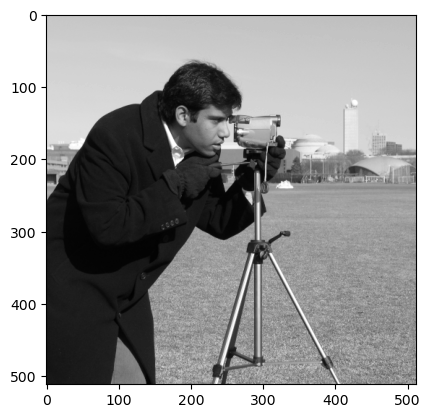

In [23]:
plt.imshow(camera, cmap='gray')

The image here is widely used in many image processing scientific publications.

The `cmap` parameter specifies the colormap used to display the image. Matplotlib default colormap not being grayscale, passing `cmap='gray'` is needed. You can find [several predefined colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) in Matplotlib. 

You can also check the images distributed with `scikit-image` on their [github repository](https://github.com/scikit-image/scikit-image/tree/main/skimage/data). Feel free to use another image, or even one of your own.

## 1. Blurring operator

In order to efficiently deblur an image, let us design our own blurring operator. Since it will be entirely known, it will be possible to compute its inverse.

Let us consider an input vector $x=\begin{pmatrix}x_0 \\ x_1 \\ ... \\ x_{N-1}\end{pmatrix} \in \mathbb{R}^N$. 

Our blurring operator $B$ will do two things:
- replace each value $x_k$ by the average of $2p+1$ values surrounding $x_k$, i.e. between $x_{k-p}$ and $x_{k+p}$.
- compute this average not for every $x_k$ but only every $s$ values, with $s$ being a subsampling factor, $s>0$.

Formally, if we denote by $y$ the output of the blurring operator on $x$, this means that
- $y\in\mathbb{R}^M$, with $M=\frac{N}{s}$ (NOTE: we will only consider the case where $N$ is a mutiple of $s$)
- $y_m = \frac{1}{2p+1}\sum_{k=sm-p}^{sm+p}x_k$

As you may have noticed, our summation indices in the definition of $y_m$ can be negative in some cases and bigger than $N-1$ in others. In those cases the missing value of $x_k$ is replaced by 0. This way of handling borders is often referred to as **zero-padding**, as it can be achieved by creating an extended version of $x$ with a number of leading and trailing zeros. There are other ways of handling borders, e.g. by using $x_0$ for negative indices and $x_{N-1}$ for indices greater than $N-1$, or even by mirroring the input vector.

1. Write a function that creates the matrix $B$ that performs the operations described above.

Remember that in python the `//` operator performs the integer division.

**!!Warning!!** the automated tests are here to help you, they might however be incomplete and do not fully guarantee that your implementation is correct even if they all pass !

In [9]:
def blur_matrix(N, p, s):
    """
    Computes the blurring matrix 

    Parameters
    ----------
    N : length of the input signal
    p : half-length of the blurring filter
    s: subsampling factor

    Returns
    -------
    The blurring matrix 
    """
    # BEGIN SOLUTION
    if N % s != 0:
        raise ValueError("N should be a multiple of s")
    M = N//s
    B = np.zeros((M, N))
    for k in range(M):
        # use zero padding as boundary conditions
        lwr_bound = max(0, k*s - p)
        upper_bound = min(N, k*s + p + 1)
        br = np.arange(lwr_bound, upper_bound)
        B[k, br] = np.ones(len(br))/(2*p + 1)
       
    return B
    # END SOLUTION

In [ ]:
grader.check("q2p1")

<!-- BEGIN QUESTION -->

2. What is the rank of $B$ ? 

Hint: 
- row-rank might be easier to consider
- you might also need to add constraints on $s$ and $p$

_Type your answer here, replacing this text._

If the parameters are chosen s.t. there is no 0 columns (that is if you subsample not too agressively, i.e. if $s\leq2p+1$) the rank of $B$ will be $M$ (all the rows are clearly independent), i.e. the matrix is onto and has a right inverse.

<!-- END QUESTION -->

## 2. Blurring the image

We now have our blurring matrix ready, let us use it to blur the `camera` image.
As $B$ is designed to operate on vectors, we will need two steps to blur the image
- apply $B$ on each column of the input image
- apply $B$ on each row of the column-blurred image computed above

3. Implement a function that blurs an image using the matrix defined in the previous question

In [49]:
def blur_image(img, B):
    """
    Blurs the input image using the blur matrix

    Parameters
    ----------
    img : input image
    B : blur matrix

    Returns
    -------
    The blurred image 
    """
    # BEGIN SOLUTION
    # Here is the detailed version, we first blur the columns then the rows
    # img_blur_c = B@img 
    # img_blurred = (B@img_blur_c.T).T # apply on rows
    
    # once you resolve the transpose operations you get the simplified version
    img_blurred = B@img@B.T
    
    return img_blurred
    # END SOLUTION

In [ ]:
grader.check("q2p3")

In [60]:
# build the blur matrix
B = blur_matrix(512, 3, 2)

In [39]:
# Blur on rows
camera_blurred = blur_image(camera, B)

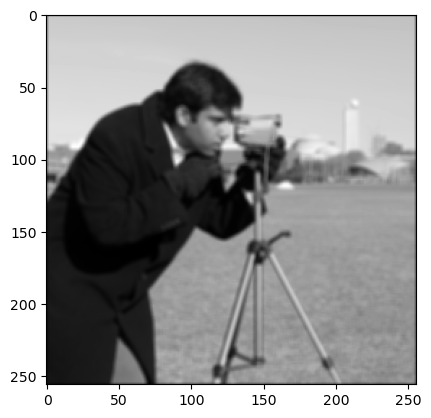

In [40]:
plt.imshow(camera_blurred, cmap='gray') # check the result

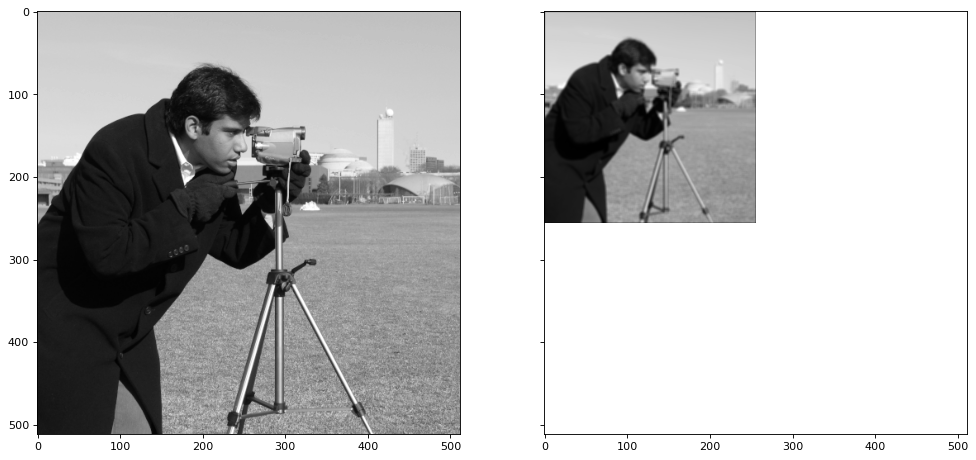

In [41]:
# Display blurred and original side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[1].imshow(camera_blurred, cmap='gray')
ax[0].imshow(camera, cmap='gray')

## 3. Deblurring
Now everything is setup, we can proceed with the image restoration. 

<!-- BEGIN QUESTION -->

4.  Let us denote the result of a blur operation by $y=Bx$. Show that $x^* = B_R^{-1}y$, where $B_R^{-1}$ is the right-inverse of $B$, is an admissible value for $x$ to satisfy $y=Bx$. Using this result and looking at the first exercise, find a possible solution for the complete blurring operation (on both rows and columns).

_Type your answer here, replacing this text._

We have $y=Bx$. Choosing $x^* = B_R^{-1}y$, where $B_R^{-1}$ is the right-inverse of $B$ yields to $Bx^* = BB_R^{-1}y = y$. 

$x^*$ is a valid input that will generate the blurred output.

The right inverse of $B$ is $B_R^{-1}= B^T(BB^T)^{-1}$. If we recall the first exercise, if a matrix admits a left inverse, its transpose has a right inverse. In this case, the full (column + rows) blurring operation can be written as $BXB^T$ (if the input image is denoted by $X$).

Similarly to the first exercise, if a matrix has a right inverse, its transpose has a left inverse which is the transpose of the right inverse. 

Let us denote by $Y = BXB^T$ the blurred image. We can then chose $X^*=B_R^{-1}YB_R^{-1T}$. Using the previous step, we can rewrite $B_R^{-1T} = {B^T_L}^{-1}$. It is quite easy to see that $X^*$ is a valid solution of the overall blurring operation (rows and columns) s.t. $BX^*B^T=Y$. 

<!-- END QUESTION -->

5. Implement a function that computes the right inverse of the blur matrix, and uses it preform image restoration. Do not forget to consider row and columns blurring.

You can use `np.linalg.inv` to perform the inverse of a matrix.

In [55]:
def inverse_blur(blurred_img, B):
    # BEGIN SOLUTION
    
    # Compute the right inverse of B
    Br_inv = B.T@np.linalg.inv(B@B.T)  
    
    # you can either do the full un-blurring in one operation or do it separately for rows and columns
    #  img_unblur_row = (Br_inv@blurred_img.T).T # reconstruct rows -  this can be simplified into: blurred_img@Br_inv.T
    #  return Br_inv@img_unblur_row #  reconstruct columns
    
    return Br_inv@blurred_img@Br_inv.T
    # END SOLUTION

In [ ]:
grader.check("q2p5")

Using this function, compute the reconstructed image from the blurred one

In [61]:
camera_unblur = inverse_blur(camera_blurred, B)

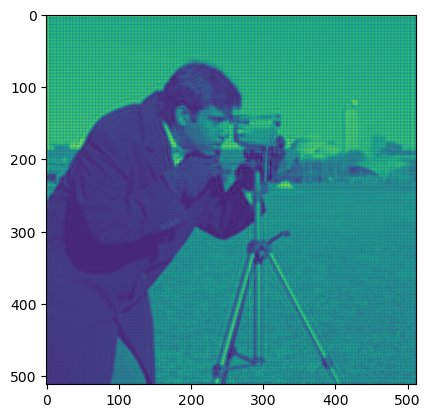

In [62]:
plt.imshow(camera_unblur) # check the result

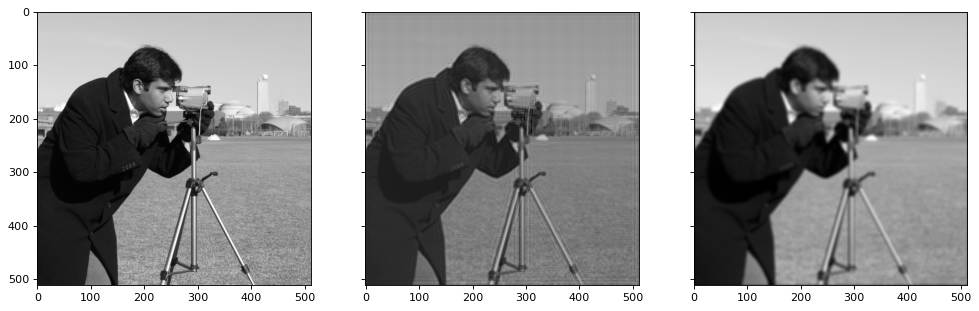

In [63]:
# Let us compare the original image, the restored image and an upscaled version of the blurred image
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), dpi=80, sharey=True, sharex=True)
ax[1].imshow(camera_unblur, cmap='gray')
ax[0].imshow(camera, cmap='gray')
ax[2].imshow(skimage.transform.resize(camera_blurred, (512,512)), cmap='gray')

<!-- BEGIN QUESTION -->

6. Evaluate the performance of the restoration method. What are its limitations for a real-world usage ? Check that the computed solution is valid by blurring the restored image.

_Type your answer here, replacing this text._

We can see that the image reconstruction (center image, original on left) is not perfect (that would be too easy). While some details are restored, the result suffers from a fair amount of distortion. However just scaling up the blurred image (rightmost image) is clearly worse.

Clearly in a real-world situation having access to the blurring matrix is the limitation of the method (there are however ways of estimating it).

However if we recompute the blurred version using the output of our deblurring method:

In [64]:
# BEGIN SOLUTION
camera_reblur = blur_image(camera_unblur, B)
diff = (camera_reblur - camera_blurred)
display(np.min(diff))
display(np.max(diff))
# END SOLUTION

-3.979039320256561e-13

4.263256414560601e-13

We can see that while $x^*$ is a valid solution, it is (by far) not the optimal one ! As the matrix $B$ is only onto (and not 1-1) we will have several admissible solutions that satisfy $y=Bx$. The right inverse is only one of them.

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)